In [1]:
import sys
sys.path.append("../../")

from astronn.datasets import deltascuti, bedding, corot ,starmodels
from astronn import models

import tensorflow as tf
from tensorflow import keras

import numpy as np
import math
import pandas as pd
import shap
from scipy.signal import find_peaks, peak_widths
import pickle

import matplotlib.pyplot as plt

Using TensorFlow backend.


### Some examples of star models

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the ver

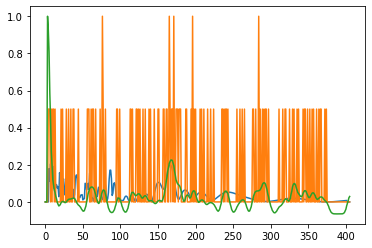

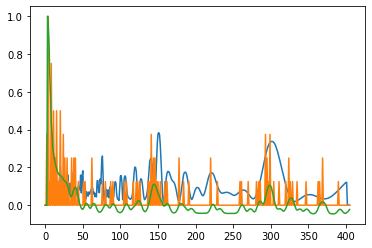

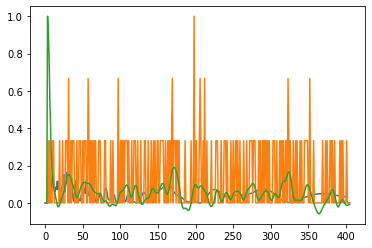

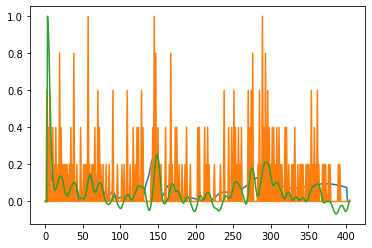

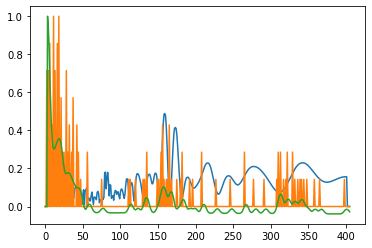

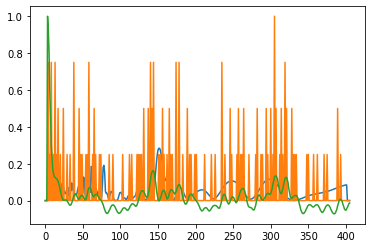

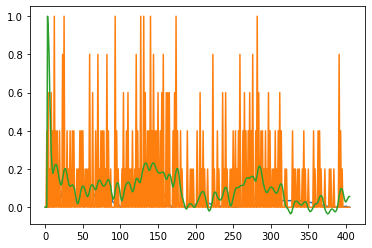

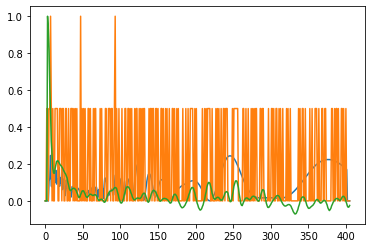

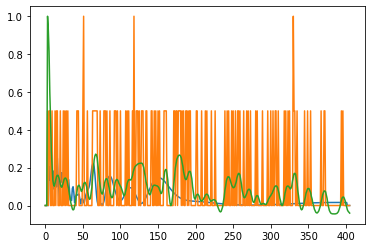

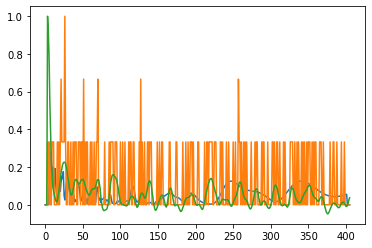

In [2]:
bedding_stars = bedding()
df_bedding = bedding_stars.load("../data/bedding/preprocessed/*", batch_size=1)
for star in df_bedding.take(10):
    #print(np.where(star[1]==1))
    plt.plot(star[1][0, :, 0])
    plt.plot(star[1][0, :, 1])
    plt.plot(star[1][0, :, 2])
    plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

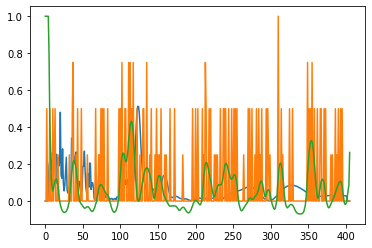

(array([0]), array([66]))


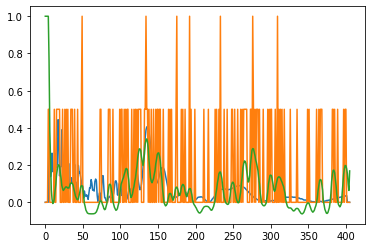

(array([0]), array([57]))


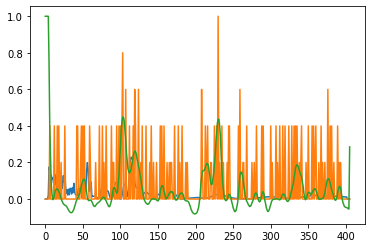

(array([0]), array([34]))


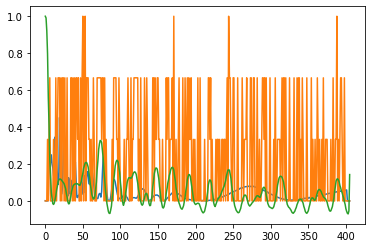

(array([0]), array([59]))


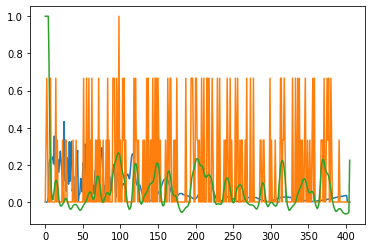

(array([0]), array([29]))


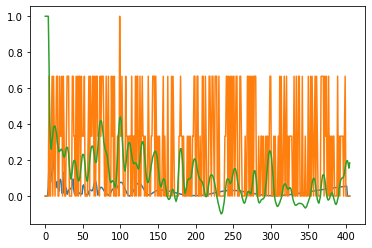

(array([0]), array([49]))


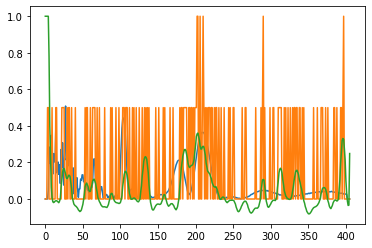

(array([0]), array([38]))


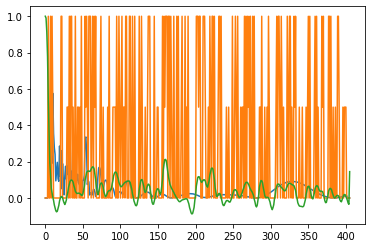

(array([0]), array([41]))


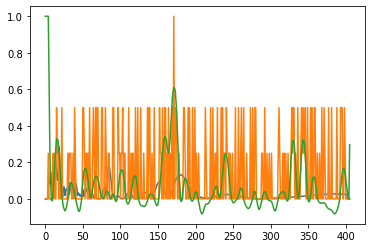

(array([0]), array([20]))


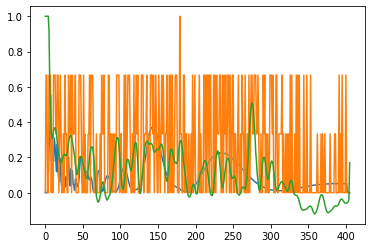

In [3]:
df = starmodels().load("/home/roberto/Downloads/dataall_parts/*", batch_size=1, add_noise=True)
for star in df.take(10):
    print(np.where(star[1]==1))
    plt.plot(star[0][0, :, 0])
    plt.plot(star[0][0, :, 1])
    plt.plot(star[0][0, :, 2])
    plt.show()

### The next Period-Luminosity relation is obtained by using the data provided in McNamara (2011):

$\log_{10} \text{L}_\odot = 1.4722 (0.100) \log_{10} \text{P} + 2.6089 (0.096)$

&nbsp;
&nbsp;


### Period (variable $\text{P}$) is isolated to obtained its value given the Luminosity.

$\log_{10} \text{L}_\odot - 2.6089 (0.096) = 1.4722 (0.100) \log_{10} \text{P}$

$\log_{10} \text{P} = \Large\frac{\log_{10} \text{L}_\odot - 2.6089 (0.096)}{1.4722 (0.100)}$

$\text{P} = 10\Large^{\Large\frac{\log_{10} \text{L}_\odot - 2.6089 (0.096)}{1.4722 (0.100)}}$

&nbsp;

The fundamental radial mode $\text{P}_0$ is related to the mean density by the pulsation constant $\text{Q} = \text{P} \cdot \Large\sqrt{\frac{\rho}{\rho_\odot}}$ (see Breger, 1990). For $\text{P}_0$ the value of $\text{Q} = [0.03, 0.0492] \text{ (days)}$

Thus, by isolating $\frac{\rho}{\rho_\odot}$ in the above equation and given the value of $\text{P}$, we have a direct estimation of the mean density, as follows:

&nbsp;

$\Large\frac{\rho}{\rho_\odot} = \Big( \frac{Q}{P}\Big)^2$

In [4]:
def get_log_l(P, A=1.4722, e_A=0.1, B=2.6089, e_B=0.096):
    """
    P-L relation for McNamara (2011)
    """
    return A * np.log10(P) + B


def get_P(log_L, A=1.4722, e_A=0.1, B=2.6089, e_B=0.096):
    """
    P variable isolated from log_L relation
    """
    return np.power(10, (log_L - B) / (A))

def get_rho_from_P(P, Q=0.033):
    """
    """
    return np.power(Q/P, 2)

# Example
P = 2.34
log_l = get_log_l(P=P)
P_equation = get_P(log_L=log_l)
print("P value = %f" % P)
print("log L is equal to %f" % log_l)
print("P from equation %f" % P_equation)
# Assert results
np.testing.assert_almost_equal(P, P_equation)

P value = 2.340000
log L is equal to 3.152460
P from equation 2.340000


### Relate to the error, we use a standard error propagation to calculate it:

$\Delta P = \sqrt{\Big(\frac{\delta \text{P}}{\delta \text{A}}\Delta\text{A}\Big)^2  +  \Big(\frac{\delta \text{P}}{\delta \text{B}}\Delta\text{B}\Big)^2   +    \Big(\frac{\delta \text{P}}{\delta \text{L}}\Delta\text{L}\Big)^2}$ where $A = 1.4722$ with uncertainty $\Delta A = 0.100$ and $B = 2.6089$ with uncertainty $\Delta B = 0.096$

$\Delta P = \sqrt{ \Big( 10^{\frac{\text{L}_\odot - B}{A}}  * (2.30258509 * A^2) * \text{L}_\odot * \Delta A \Big)^2 + \Big( 10^{\frac{\text{L}_\odot - B}{A}}  * (2.30258509 * A) *  \Delta B \Big)^2}$


&nbsp;

## Range of $\rho$ used through PL relation

To calculate a valid PL window, we will use the next range:

$\Large[ \frac{\rho}{\rho_\odot}_{\min} = \Big( \frac{0.033}{P+\Delta_p}\Big)^2, \frac{\rho}{\rho_\odot}_{\max} = \Big( \frac{0.042}{P-\Delta_p}\Big)^2 \Large]$

In [5]:
def p_error(log_L, A=1.4722, e_A=0.1, B=2.6089, e_B=0.096):
    """
    """
    return np.sqrt(
        np.power(
            np.power(10, (log_L - B) / A) * (2.30258509 / np.power(A, 2)) * log_L * e_A,
            2,
        )
        + np.power(np.power(10, (log_L - B) / A) * (2.30258509 / A) * e_B, 2)
    )


l_value = 1.3
print(
    "Period for L=%f is equal to %f +-(%f)"
    % (l_value, get_P(log_L=1.3), p_error(log_L=1.3))
)

Period for L=1.300000 is equal to 0.129099 +-(0.026337)


### Relation Rodriguez-Martin et.al. 2020

$\frac{\bar{\rho}}{\rho} = 1.6^{+0.5}_{-0.4} \Big( \langle\Delta\nu\rangle / \Delta\nu_\odot \Big)^{2.02^{+0.10}_{-0.10}}$

For the moment, we will use a simetric error in the first term i.e.: $1.6^{+0.5}_{-0.5}$

$\Delta \frac{\bar{\rho}}{\rho} = \sqrt{\Big(\frac{\delta \frac{\bar{\rho}}{\rho}}{\delta \text{A}}\Delta\text{A}\Big)^2  +  \Big(\frac{\delta \frac{\bar{\rho}}{\rho}}{\delta \text{B}}\Delta\text{B}\Big)^2 }$ where $A = 1.6$ with uncertainty $\Delta A = 0.5$ and $B = 2.02$ with uncertainty $\Delta B = 0.1$

$\Delta \frac{\bar{\rho}}{\rho}  = \sqrt{ ( {\langle\Delta\nu\rangle / \Delta\nu_\odot} )^B * \Delta \text{A} )^2 +  (A * ( {\langle\Delta\nu\rangle / \Delta\nu_\odot} )^B + \log_{10}(x) * \Delta B)^2 }$


&nbsp;
&nbsp;

Inversely, we can get $\Delta \nu$ from $\rho$ as follows:

$\langle\Delta\nu\rangle / \Delta\nu_\odot = \Big( \frac{\frac{\bar{\rho}}{\rho}}{1.6^{+0.5}_{-0.4}} \Big)^{\big(2.02^{+0.10}_{-0.10} \big)^{-1}}$

$\langle\Delta\nu\rangle / \Delta\nu_\odot = \sqrt{\Big(\frac{\delta \langle\Delta\nu\rangle / \Delta\nu_\odot}{\delta \text{A}}\Delta\text{A}\Big)^2  +  \Big(\frac{\delta \langle\Delta\nu\rangle / \Delta\nu_\odot}{\delta \text{B}}\Delta\text{B}\Big)^2 }$ where $A = 1.6$ with uncertainty $\Delta A = 0.5$ and $B = 2.02$ with uncertainty $\Delta B = 0.1$

$\langle\Delta\nu\rangle / \Delta\nu_\odot = \sqrt{  -(Y * 1/(\ln(B) * Y/A) * \Delta A)^2 + (-\log(Y/A)*1/B/\ln(B)^2 * \Delta B)^2 }$



In [6]:
def get_rho(delta_nu):
    """
    """
    return 1.6 * np.power(delta_nu, 2.02)


def rho_error(delta_nu, A=1.6, e_A=0.5, B=2.02, e_B=0.1):
    """
    """
    return np.sqrt(
        np.power(np.power(delta_nu, B) * e_A, 2) 
        + np.power(A * np.power(delta_nu, B) * np.log10(delta_nu) * e_B, 2)
    )

delta_nu_value = 1.3
print(
    "Delta_nu == %f is a rho equal to %f +-(%f)"
    % (l_value, get_rho(delta_nu=delta_nu_value), rho_error(delta_nu=delta_nu_value))
)

Delta_nu == 1.300000 is a rho equal to 2.718226 +-(0.850010)


In [7]:
def get_dnu_from_rho(rho):
    """
    """
    return math.pow(rho / 1.6, math.pow(2.02, -1))


def dnu_error(rho, A=1.6, e_A=0.0, B=2.02, e_B=0.1):
    """
    """
    return np.sqrt(
        math.pow(
            -math.pow(rho / A, 1 / B - 1) * (1 / B / math.pow(A, 2)) * rho * e_A, 2
        )
        + math.pow(
            -math.pow(rho / A, 1 / B)
            / math.pow(B, 2)
            * math.log(rho / A, math.e)
            * e_B,
            2,
        )
    )

rho = 2.718226
print(
    "rho == %f is a Delta_nu equal to %f +-(%f)"
    % (rho, get_dnu_from_rho(rho=rho), dnu_error(rho=rho))
)

# Assert results
np.testing.assert_almost_equal(get_dnu_from_rho(rho=rho), delta_nu_value)

rho == 2.718226 is a Delta_nu equal to 1.300000 +-(0.016885)


In [8]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', label="x "+str(slope))

#### Load pre-trained NN model

In [9]:
# Load model
#sepconv_mod = tf.keras.models.load_model("/home/roberto/Projects/sepconvnn_tmp_400/")
#sepconv_mod = tf.keras.models.load_model("/home/roberto/Projects/sepconvnn_tmp_400_2/")
sepconv_mod = tf.keras.models.load_model("/tmp/sepconvnn_tmp_150/")
sepconv_mod.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv1d (SeparableC (None, 397, 10)           310       
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 393, 10)           760       
_________________________________________________________________
batch_normalization (BatchNo (None, 393, 10)           40        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 196, 10)           0         
_________________________________________________________________
dropout (Dropout)            (None, 196, 10)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1960)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               1

## Read an process 11 binaries DS

##### Calculate Luminosity

In [10]:
csv_ds = pd.read_csv("../data/deltascuti/binaries_obs.csv")
print(csv_ds.head(20))

# 1 mas = 0.00099999995874704 arcsec
Mv = csv_ds["mv"] + 5 * (np.log10(csv_ds["parallax"] * 0.00099999995874704) + 1)
mbolsun = 4.74
# calculate Luminosity
csv_ds["L"] = (np.power(10, 0.4 * (mbolsun - Mv))) * csv_ds["L.Ltot"]

# Filter columns and add HD15082 info300
csv_ds = csv_ds[["ID", "Dnu_muHz", "L", "Teff", "L.Ltot", "parallax", "mv"]]
csv_ds.loc[csv_ds['ID'] == "HD15082", ['L']] = 6.14
csv_ds.loc[csv_ds['ID'] == "HD15082", ['Dnu_muHz']] = 80
# Updated CID100866999 with Gaia Luminosity
csv_ds.loc[csv_ds['ID'] == "CID100866999", ['L']] = 3.865

csv_ds.head(11)
#csv_ds.to_csv("../data/deltascuti/binaries_obs.csv", index=False, header=True)

              ID  Dnu_muHz          L  Teff  L.Ltot  parallax       mv
0     KIC3858884        29  21.520774  6606   0.470    1.7800   9.3360
1     KIC4544587        74   6.475306  7750   0.332    1.3600  10.8470
2    KIC10661783        39  29.304625  7764   0.937    1.9400   9.5630
3       HD172189        19  29.942319  7750   0.702    2.2700   8.8850
4   CID100866999        56   3.865000  7300     NaN    0.5654  15.0970
5   CID105906206        20   9.396579  6750   0.940    0.9901  12.2620
6       HD159561        38  24.642612  8047   1.000   67.1300   2.1262
7     KIC9851944        26  60.062351  6902   0.500    0.4100  11.4770
8     KIC8262223        77   5.139949  9128   0.900    0.9832  12.8850
9    KIC10080943        52   7.085301  7480   0.500    1.0600  11.7350
10       HD15082        80   6.140000     0   0.000    0.0000   0.0000


ID  Dnu_muHz          L  Teff  L.Ltot  parallax       mv
0     KIC3858884        29  21.520774  6606   0.470    1.7800   9.3360
1     KIC4544587        74   6.475306  7750   0.332    1.3600  10.8470
2    KIC10661783        39  29.304625  7764   0.937    1.9400   9.5630
3       HD172189        19  29.942319  7750   0.702    2.2700   8.8850
4   CID100866999        56   3.865000  7300     NaN    0.5654  15.0970
5   CID105906206        20   9.396579  6750   0.940    0.9901  12.2620
6       HD159561        38  24.642612  8047   1.000   67.1300   2.1262
7     KIC9851944        26  60.062351  6902   0.500    0.4100  11.4770
8     KIC8262223        77   5.139949  9128   0.900    0.9832  12.8850
9    KIC10080943        52   7.085301  7480   0.500    1.0600  11.7350
10       HD15082        80   6.140000     0   0.000    0.0000   0.0000

In [11]:
for l_value in csv_ds["L"]:
    print(
    "Period for L=%f is equal to %f +-(%f)"
    % (l_value, get_P(log_L=np.log10(l_value)), p_error(log_L=np.log10(l_value)))
    )

Period for L=21.520774 is equal to 0.135907 +-(0.028049)
Period for L=6.475306 is equal to 0.060110 +-(0.010407)
Period for L=29.304625 is equal to 0.167616 +-(0.036273)
Period for L=29.942319 is equal to 0.170085 +-(0.036929)
Period for L=3.865000 is equal to 0.042336 +-(0.006883)
Period for L=9.396579 is equal to 0.077408 +-(0.014111)
Period for L=24.642612 is equal to 0.149005 +-(0.031399)
Period for L=60.062351 is equal to 0.272908 +-(0.065866)
Period for L=5.139949 is equal to 0.051382 +-(0.008636)
Period for L=7.085301 is equal to 0.063900 +-(0.011197)
Period for L=6.140000 is equal to 0.057977 +-(0.009967)


In [12]:
# Load Teff,Dnu -> L model from star models
with open("../models/gam_teff_dnu/gam.pkl", 'rb') as f:
    gam_teff_dnu = pickle.load(f)
gam_teff_dnu.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     84.6873
Link Function:                     IdentityLink Log Likelihood:                               -960654.4226
Number of Samples:                       494768 AIC:                                          1921480.2198
                                                AICc:                                         1921480.2499
                                                GCV:                                                2.2207
                                                Scale:                                                2.22
                                                Pseudo R-Squared:                                   0.9958
Feature Function                  Lam

In [13]:
def get_peak_width(position, peaks, peaks_width, peaks_sorted_by_prob):
    """
    """
    peak_id = np.where(probs == peaks_sorted_by_prob[position])[0][0]
    return (peak_id, peaks_width[0][np.where(peaks == peak_id)[0][0]])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the ver

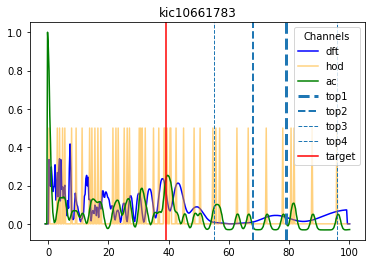

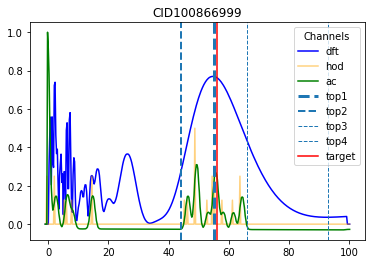

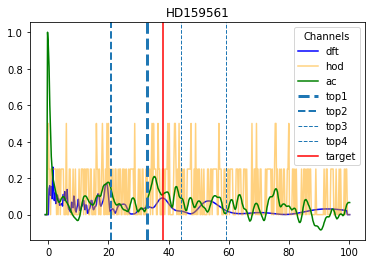

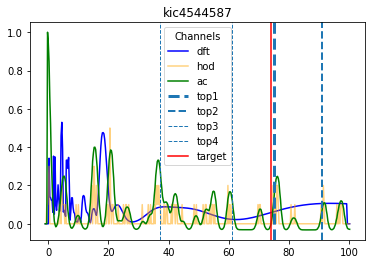

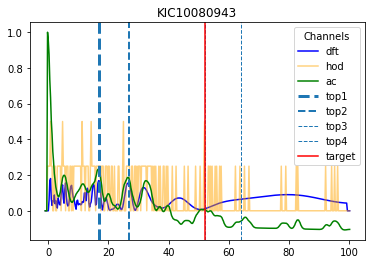

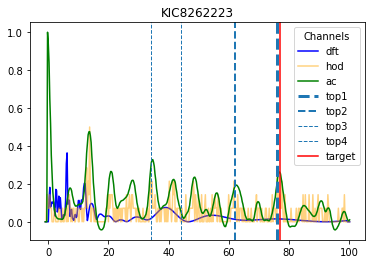

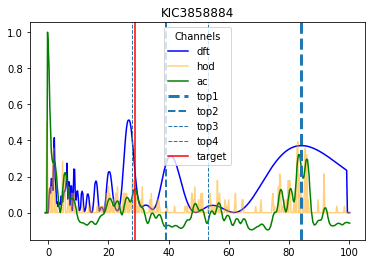

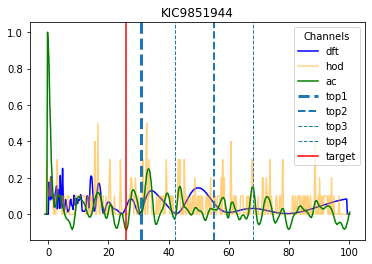

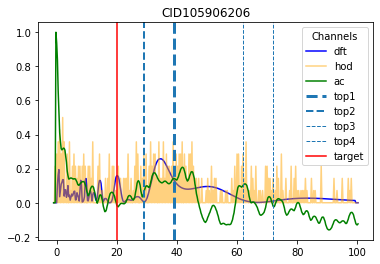

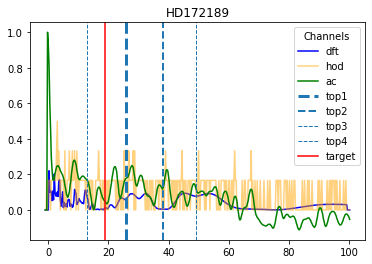

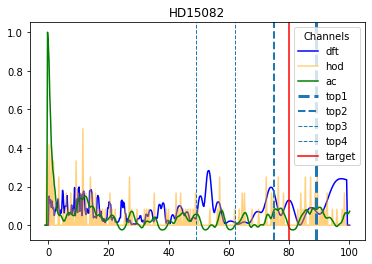

In [14]:
dnu_sun = 134.8

# Read datasets of preprocessed stars
df_ds = deltascuti()
df = df_ds.load("../../astronn/data/deltascuti/preprocessed/*", batch_size=1)
# Read star models (trainning) to calculate shap values
star_models = starmodels()
df_sm = star_models.load("/home/roberto/Downloads/dataall_parts/*", batch_size=150, add_noise=True)
#df_sm = star_models.load("/home/roberto/Downloads/evolutionTracks_line_noisy/parts/*", batch_size=150, add_noise=False)
#df_sm = star_models.load("/home/roberto/Downloads/evolutionTracks_line_lum/parts/*", batch_size=250, add_noise=False)
_train_shap = np.asarray([line[0].numpy() for line in df_sm.take(10)])
_train_shap = _train_shap.reshape(
    (
        _train_shap.shape[0] * _train_shap.shape[1],
        _train_shap.shape[2],
        _train_shap.shape[3],
    )
)

# Save results and predictions
results = {}
for star in df.take(11):  # take the 11 ds stars
    target = np.where(star[2].numpy().flat == 1)[0].flat[0]
    # Save results
    if star[0].numpy()[0].decode("utf-8") not in results:
        results[star[0].numpy()[0].decode("utf-8")] = {
            "dnu-target": target,
        }

    probs = sepconv_mod.predict_proba(star[1])[0]
    peaks, _ = find_peaks(probs, height=0, distance=10)
    peaks_width = peak_widths(probs, peaks)
    peaks_sorted_by_prob = np.sort(probs[peaks])[::-1]
    best_peak, best_peak_width = get_peak_width(0, peaks, peaks_width, peaks_sorted_by_prob)

    # save top-k
    results[star[0].numpy()[0].decode("utf-8")]["top1"] = np.where(
        probs == peaks_sorted_by_prob[0]
    )[0][0]
    # Get error
    results[star[0].numpy()[0].decode("utf-8")]["e-top1"] = best_peak_width

    # save top-k
    results[star[0].numpy()[0].decode("utf-8")]["top2"] = np.where(
        probs == peaks_sorted_by_prob[1]
    )[0][0]
    # Get error
    best_peak, best_peak_width = get_peak_width(1, peaks, peaks_width, peaks_sorted_by_prob)
    results[star[0].numpy()[0].decode("utf-8")]["e-top2"] = best_peak_width

    # save top-k
    results[star[0].numpy()[0].decode("utf-8")]["top3"] = np.where(
        probs == peaks_sorted_by_prob[2]
    )[0][0]
    # Get error
    best_peak, best_peak_width = get_peak_width(2, peaks, peaks_width, peaks_sorted_by_prob)
    results[star[0].numpy()[0].decode("utf-8")]["e-top3"] = best_peak_width

    # save top-k
    results[star[0].numpy()[0].decode("utf-8")]["top4"] = np.where(
        probs == peaks_sorted_by_prob[3]
    )[0][0]
    # Get error
    best_peak, best_peak_width = get_peak_width(3, peaks, peaks_width, peaks_sorted_by_prob)
    results[star[0].numpy()[0].decode("utf-8")]["e-top4"] = best_peak_width


    # Get L from Teff,Dnu model
    L = csv_ds[csv_ds.ID.eq(star[0].numpy()[0].decode("utf-8").upper())]["L"].values
    Teff = csv_ds[csv_ds.ID.eq(star[0].numpy()[0].decode("utf-8").upper())][
        "Teff"
    ].values
    if len(L) > 0 and not np.isnan(L) and not np.isnan(Teff):
        l_teff_topk1 = gam_teff_dnu.predict(
            np.asarray(
                [results[star[0].numpy()[0].decode("utf-8")]["top1"], Teff]
            ).reshape(1, 2)
        )[0]

        l_teff_topk2 = gam_teff_dnu.predict(
            np.asarray(
                [results[star[0].numpy()[0].decode("utf-8")]["top2"], Teff]
            ).reshape(1, 2)
        )[0]
        l_teff_topk3 = gam_teff_dnu.predict(
            np.asarray(
                [results[star[0].numpy()[0].decode("utf-8")]["top3"], Teff]
            ).reshape(1, 2)
        )[0]


        # Get L errors
        ls_teff_topks = [l_teff_topk1, l_teff_topk2, l_teff_topk3]
        # Get L errors
        errors = [
            round(np.power(l_teff_topk1 - L[0], 2), 2),
            round(np.power(l_teff_topk2 - L[0], 2), 2),
            round(np.power(l_teff_topk3 - L[0], 2), 2)
        ]
        i = np.argmin(errors)  # Get min error position
        L = ls_teff_topks[i]  # Get most probable L from the model

        P = get_P(np.log10(L))
        p_e = p_error(log_L=np.log10(L))
        rho_q_up = get_rho_from_P(P - p_e, Q=0.042)
        rho_q_down = get_rho_from_P(P + p_e, Q=0.033)
        results[star[0].numpy()[0].decode("utf-8")][
            "dnu-from-P-up-fromstarmodel"
        ] = get_dnu_from_rho(rho_q_up) * dnu_sun
        results[star[0].numpy()[0].decode("utf-8")][
            "dnu-from-P-down-fromstarmodel"
        ] = get_dnu_from_rho(rho_q_down) * dnu_sun
    else:
        results[star[0].numpy()[0].decode("utf-8")][
            "dnu-from-P-up-fromstarmodel"
        ] = np.nan
        results[star[0].numpy()[0].decode("utf-8")][
            "dnu-from-P-down-fromstarmodel"
        ] = np.nan

    # Get P from L
    # Check for non L in csv or NaN value
    L = csv_ds[csv_ds.ID.eq(star[0].numpy()[0].decode("utf-8").upper())]["L"].values
    if len(L) > 0 and not np.isnan(L):
        P = get_P(np.log10(L))
        p_e = p_error(log_L=np.log10(L))
        rho_q_up = get_rho_from_P(P - p_e, Q=0.042)
        rho_q_down = get_rho_from_P(P + p_e, Q=0.033)
        results[star[0].numpy()[0].decode("utf-8")]["dnu-from-P-up"] = get_dnu_from_rho(rho_q_up[0]) * dnu_sun
        results[star[0].numpy()[0].decode("utf-8")]["dnu-from-P-down"] = get_dnu_from_rho(rho_q_down[0]) * dnu_sun
    else:
        print(star[0].numpy()[0].decode("utf-8"))
        print(L)
        results[star[0].numpy()[0].decode("utf-8")]["dnu-from-P-up"] = np.nan
        results[star[0].numpy()[0].decode("utf-8")]["v-from-P-down"] = np.nan

    if True:
        x = np.arange(-1, 100.5, 0.25)  # x axis from 0 to 100
        plt.plot(x, star[1][0, :, 0], label="dft", color="blue")
        plt.plot(x, star[1][0, :, 1], label="hod", color="orange", alpha=0.5)
        plt.plot(x, star[1][0, :, 2], label="ac", color="green")
        plt.axvline(x=results[star[0].numpy()[0].decode("utf-8")]["top1"], label="top1", linestyle="dashed", linewidth = 3)
        plt.axvline(x=results[star[0].numpy()[0].decode("utf-8")]["top2"], label="top2", linestyle="dashed", linewidth = 2)
        plt.axvline(x=results[star[0].numpy()[0].decode("utf-8")]["top3"], label="top3", linestyle="dashed", linewidth = 1)
        plt.axvline(x=results[star[0].numpy()[0].decode("utf-8")]["top4"], label="top4", linestyle="dashed", linewidth = 1)
        plt.axvline(x=target, label="target", color="red")
        plt.title(star[0].numpy()[0].decode("utf-8"))
        plt.legend(title="Channels")
        plt.show()

In [15]:
df = pd.DataFrame(
    columns=[
        "id",
        "dnu-target",
        "top1",
        "e-top1",
        "top2",
        "e-top2",
        "top3",
        "e-top3",
        "top4",
        "e-top4",
        "dnu-from-P-up-fromstarmodel",
        "dnu-from-P-down-fromstarmodel",
        "dnu-from-P-up",
        "dnu-from-P-down"

    ]
)
for i, id in enumerate(results):
    df.loc[i] = [
        id,
        results[id]["dnu-target"],
        results[id]["top1"],
        results[id]["e-top1"],
        results[id]["top2"],
        results[id]["e-top2"],
        results[id]["top3"],
        results[id]["e-top3"],
        results[id]["top4"],
        results[id]["e-top4"],
        results[id]["dnu-from-P-up-fromstarmodel"],
        results[id]["dnu-from-P-down-fromstarmodel"],
        results[id]["dnu-from-P-up"],
        results[id]["dnu-from-P-down"]
    ]
df

id dnu-target top1    e-top1 top2    e-top2 top3    e-top3 top4  \
0    kic10661783         39   79  4.125579   68  0.948442   96  0.909910   55   
1   CID100866999         56   55  2.159478   44  0.831476   93  1.152922   66   
2       HD159561         38   33  2.588988   21  3.782192   44  0.792983   59   
3     kic4544587         74   75  2.051753   91  1.564733   61  2.120540   37   
4    KIC10080943         52   17  1.593633   27  1.910249   64  3.086625   52   
5     KIC8262223         77   76  1.910005   62  1.936936   44  1.799210   34   
6     KIC3858884         29   84  1.542697   39  1.847915   53  3.281405   28   
7     KIC9851944         26   31  3.801270   55  2.966093   42  2.326072   68   
8   CID105906206         20   39  3.577471   29  2.919287   62  4.060465   72   
9       HD172189         19   26  6.928191   38  2.500636   49  1.894922   13   
10       HD15082         80   89  3.605905   75  1.508796   62  1.732937   49   

      e-top4  dnu-from-P-up-fromstarmodel  dnu-from-P-down-fromstarmodel  \
0   1.370062                    64.377454                      34.895120   
1   0.762894                    80.381344                      44.381289   
2   1.828762                    43.759121                      22.863388   
3   1.517847                    77.921643                      42.917796   
4   3.593793                    75.811208                      41.663505   
5   1.865561                    49.236846                      26.030801   
6   3.964283                    67.675444                      36.842163   
7   2.426925                    51.044574                      27.081436   
8   1.496319                    64.042692                      34.697756   
9   0.640045                    32.885126                      16.666582   
10  2.321964                   111.268015                      62.857298   

    dnu-from-P-up  dnu-from-P-down  
0       34.545158        17.603175  
1      126.330451        71.900529  
2       38.537790        19.870672  
3       90.413084        50.365296  
4       85.316430        47.322315  
5      104.970838        59.080258  
6       41.985046        21.843379  
7       22.013591        10.647775  
8       71.165271        38.907339  
9       34.079468        17.340043  
10      93.569327        52.252186

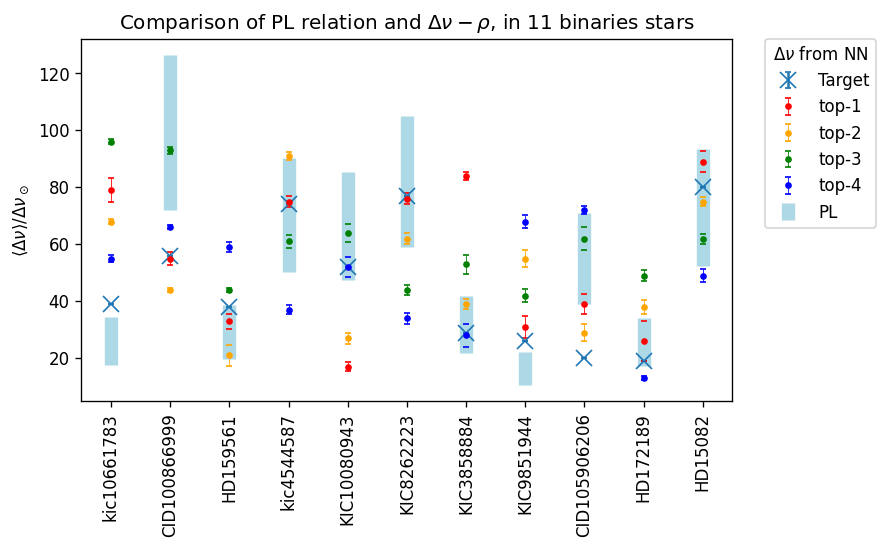

In [16]:
plt.subplots(1, figsize=(7, 4), dpi=120)

plt.errorbar(
    df["id"],
    df["dnu-target"],
    0,
    fmt="x",
    markersize=10,
    capsize=2,
    label="Target"
)

plt.errorbar(
    df["id"],
    df["top1"],
    df["e-top1"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="red",
    label="top-1",
)
plt.errorbar(
    df["id"],
    df["top2"],
    df["e-top2"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="orange",
    label="top-2",
)
plt.errorbar(
    df["id"],
    df["top3"],
    df["e-top3"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="green",
    label="top-3",
)
plt.errorbar(
    df["id"],
    df["top4"],
    df["e-top4"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="blue",
    label="top-4",
)
"""
plt.errorbar(
    df["id"],
    (df["dnu-from-P-up-fromstarmodel"] + df["dnu-from-P-down-fromstarmodel"]) / 2,
    df["dnu-from-P-up-fromstarmodel"] - ((df["dnu-from-P-up-fromstarmodel"] + df["dnu-from-P-down-fromstarmodel"]) / 2),
    elinewidth=8,
    fmt="o",
    markersize=0,
    capsize=10,
    label="PL-From Teff",
    color="blue",
)
"""
plt.errorbar(
    df["id"],
    (df["dnu-from-P-up"] + df["dnu-from-P-down"]) / 2,
    df["dnu-from-P-up"] - ((df["dnu-from-P-up"] + df["dnu-from-P-down"]) / 2),
    elinewidth=8,
    fmt="o",
    markersize=0,
    capsize=0,
    label="PL",
    color="lightblue",
)

plt.xticks(rotation=90)

plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.0,
    title=r"$\Delta\nu$ from NN",
)
#plt.gca().add_artist(legend1)
plt.ylabel("$\langle\Delta\\nu\\rangle / \Delta\\nu_\odot$")
plt.title("Comparison of PL relation and $\Delta\\nu-\\rho$, in 11 binaries stars")
#plt.ylim(0, 1.0)
plt.show()

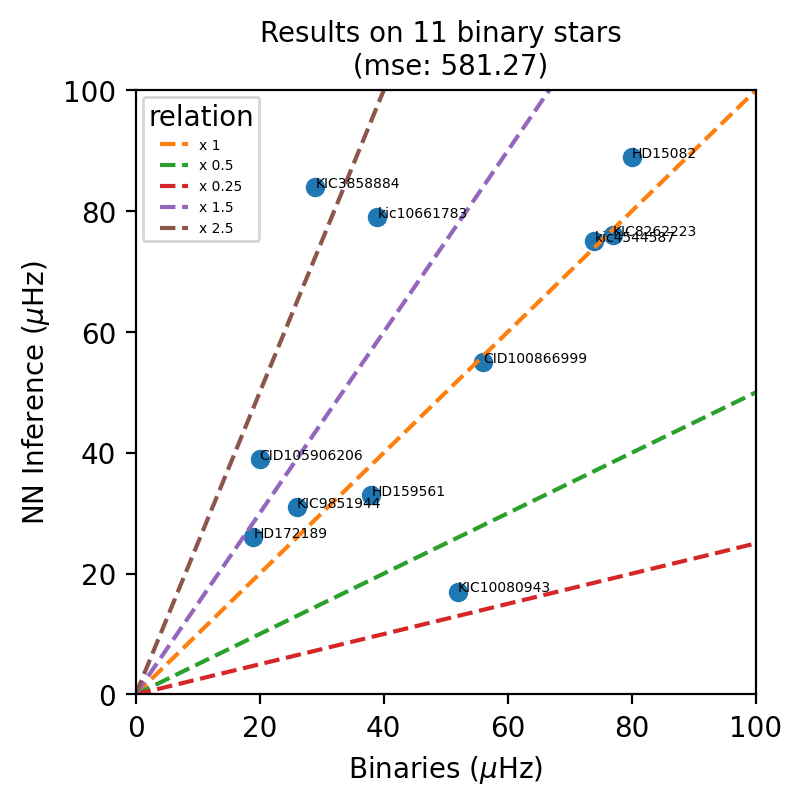

In [17]:
# Prepare data plot
targets = []
inferences = []
ids = []
for tess_id in results:
    ids.append(tess_id)
    targets.append(results[tess_id]["dnu-target"])
    inferences.append(results[tess_id]["top1"])
    
# Set lims
plt.subplots(1, figsize=(4, 4), dpi=200)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.plot(targets, inferences, "o") # Plot relation
for i, txt in enumerate(ids):
    plt.annotate(txt, (targets[i], inferences[i]), size=5)

# Add multiple and submultiples
abline(1, 0)
abline(0.5, 0)
abline(0.25, 0)
abline(1.5, 0)
abline(2.5, 0)
plt.legend(title="relation", fontsize=5)
plt.xlabel("Binaries ($\mu$Hz)")
plt.ylabel("NN Inference ($\mu$Hz)")
plt.title("Results on 11 binary stars \n (mse: %s)" % np.round(np.mean(np.power(np.asarray(targets)-np.asarray(inferences), 2)), 2), fontsize=10)
plt.show()
plt.show()

In [18]:
results_binaries = pd.DataFrame(
    columns=[
        "id",
        "dnu-target",
        "e-dnu-target",
        "dnu-from-P",
        "e-dnu-from-P",
        "best-top",
        "e-best-top",
        "ktop",
    ]
)

for index, row in df.iterrows():
    print("Proccessing star %s" % row["id"])
    print("PL[%f,%f]" % (row["dnu-from-P-up"], row["dnu-from-P-down"]))
    # Top index to search on 
    top_indexs = ["top1", "top2", "top3"]
    best = np.nan # empty on start
    # Center of PL window
    central_pl_window = row["dnu-from-P-up"]-((row["dnu-from-P-up"]-row["dnu-from-P-down"])/2)
    # Check predictions indise L window
    inside_pl_window = []
    for top_index in top_indexs:
        flag_full_inside = (row[top_index] + row["e-%s" % (top_index)] <= row["dnu-from-P-up"]) & (row[top_index] - row["e-%s" % (top_index)] >= row["dnu-from-P-down"])
        flag_partial =  ((row[top_index] - row["e-%s" % (top_index)] >= row["dnu-from-P-down"]) & (row[top_index] - row["e-%s" % (top_index)] <= row["dnu-from-P-up"])) | ((row[top_index] + row["e-%s" % (top_index)] >= row["dnu-from-P-down"]) & (row[top_index] + row["e-%s" % (top_index)] <= row["dnu-from-P-up"])) 
        if flag_full_inside or flag_partial:
            inside_pl_window.append(top_index)
    print("   =>Inside PL window: %s" % inside_pl_window)

    if (len(inside_pl_window) > 0) and (not np.isnan(row["dnu-from-P-up"])):
        print("=>",inside_pl_window)
        top_index = inside_pl_window[0] # Get most probable from NN
        
        # Get best
        best = row["%s" % (top_index)]
        results_binaries.loc[len(results_binaries)] = [
                        row["id"],
                        row["dnu-target"],
                        0.23,
                        (row["dnu-from-P-up"] + row["dnu-from-P-down"]) / 2,
                        row["dnu-from-P-up"] - ((row["dnu-from-P-up"] + row["dnu-from-P-down"]) / 2),
                        best,
                        row["e-%s" % top_index],
                        top_index
                    ]
    else:
        # Get closest inference to the center of PL window
        top_index = np.argmin([np.abs(row[top_index]-central_pl_window) for top_index in top_indexs])
        # Check if predictions is not inside window
        # Get best
        best = row["top%s" % (top_index+1)]
        results_binaries.loc[len(results_binaries)] = [
                        row["id"],
                        row["dnu-target"],
                        0.23,
                        (row["dnu-from-P-up"] + row["dnu-from-P-down"]) / 2,
                        row["dnu-from-P-up"] - ((row["dnu-from-P-up"] + row["dnu-from-P-down"]) / 2),
                        best,
                        row["e-top%s" % (top_index+1)],
                        top_index
                    ]

Proccessing star kic10661783
PL[34.545158,17.603175]
   =>Inside PL window: []
Proccessing star CID100866999
PL[126.330451,71.900529]
   =>Inside PL window: ['top3']
=> ['top3']
Proccessing star HD159561
PL[38.537790,19.870672]
   =>Inside PL window: ['top1', 'top2']
=> ['top1', 'top2']
Proccessing star kic4544587
PL[90.413084,50.365296]
   =>Inside PL window: ['top1', 'top2', 'top3']
=> ['top1', 'top2', 'top3']
Proccessing star KIC10080943
PL[85.316430,47.322315]
   =>Inside PL window: ['top3']
=> ['top3']
Proccessing star KIC8262223
PL[104.970838,59.080258]
   =>Inside PL window: ['top1', 'top2']
=> ['top1', 'top2']
Proccessing star KIC3858884
PL[41.985046,21.843379]
   =>Inside PL window: ['top2']
=> ['top2']
Proccessing star KIC9851944
PL[22.013591,10.647775]
   =>Inside PL window: []
Proccessing star CID105906206
PL[71.165271,38.907339]
   =>Inside PL window: ['top1', 'top3']
=> ['top1', 'top3']
Proccessing star HD172189
PL[34.079468,17.340043]
   =>Inside PL window: ['top1']
=> [

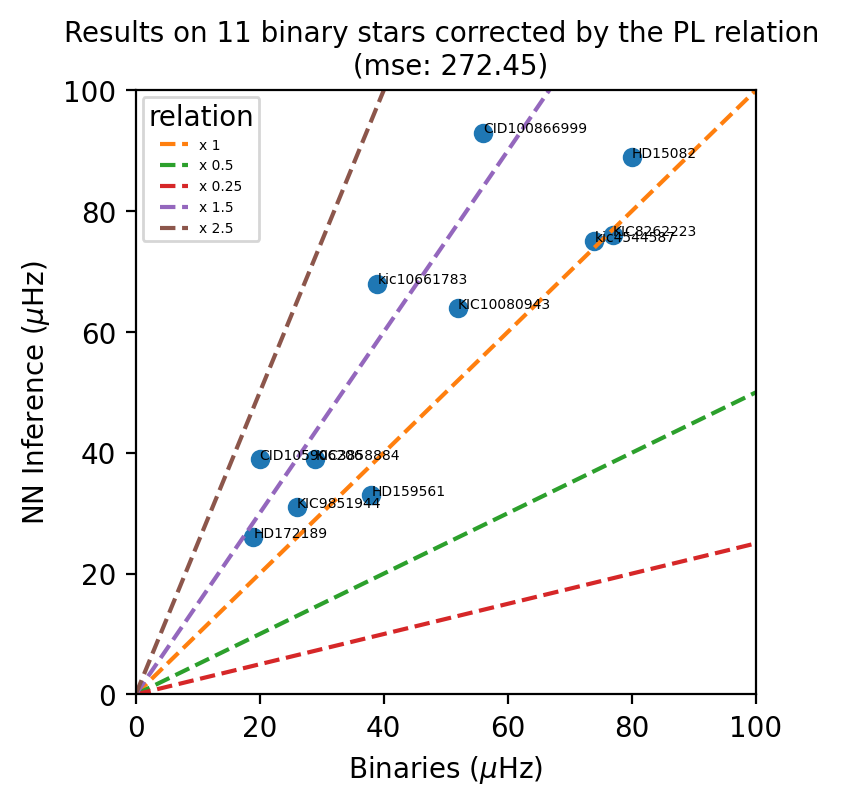

In [19]:
# Prepare data plot
targets = results_binaries["dnu-target"]
inferences = results_binaries["best-top"]
ids = results_binaries["id"]

# Set lims
plt.subplots(1, figsize=(4, 4), dpi=200)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.plot(targets, inferences, "o") # Plot relation
for i, txt in enumerate(ids):
    plt.annotate(txt, (targets[i], inferences[i]), size=5)

# Add multiple and submultiples
abline(1, 0)
abline(0.5, 0)
abline(0.25, 0)
abline(1.5, 0)
abline(2.5, 0)
plt.legend(title="relation", fontsize=5)
plt.xlabel("Binaries ($\mu$Hz)")
plt.ylabel("NN Inference ($\mu$Hz)")
plt.title("Results on 11 binary stars corrected by the PL relation \n (mse: %s)" % np.round(np.mean(np.power(np.asarray(targets)-np.asarray(inferences), 2)), 2), fontsize=10)
plt.show()

## Read and process Bedding stars 

In [20]:
# Read datasets of preprocessed stars
bedding_stars = bedding()
df_bedding = bedding_stars.load("../data/bedding/preprocessed/*", batch_size=1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


#### Read L from file

In [21]:
"""
df_att = pd.io.parsers.read_csv("../data/bedding/bedding.csv", sep=",", index_col=0)
rows = []
for i,row in pd.io.parsers.read_csv("../data/bedding/parameters.csv", sep=",", header=1, names=["star", "L", "Teff", "dnu"]).iterrows():
    print(row)
    L = df_att[df_att.TIC.eq(str(int(row["star"].split("-")[2])))]["L"].values[0]
    Teff = df_att[df_att.TIC.eq(str(int(row["star"].split("-")[2])))]["Teff"].values[0]
    rows.append([row["star"], L, Teff, row["dnu"]])
df_aux = pd.DataFrame(rows, columns = ['star', 'L', "Teff", "dnu"])  
print(df_aux.head(57))
df_aux.to_csv("../data/bedding/parameters.csv", index=False, header=True)
"""

'\ndf_att = pd.io.parsers.read_csv("../data/bedding/bedding.csv", sep=",", index_col=0)\nrows = []\nfor i,row in pd.io.parsers.read_csv("../data/bedding/parameters.csv", sep=",", header=1, names=["star", "L", "Teff", "dnu"]).iterrows():\n    print(row)\n    L = df_att[df_att.TIC.eq(str(int(row["star"].split("-")[2])))]["L"].values[0]\n    Teff = df_att[df_att.TIC.eq(str(int(row["star"].split("-")[2])))]["Teff"].values[0]\n    rows.append([row["star"], L, Teff, row["dnu"]])\ndf_aux = pd.DataFrame(rows, columns = [\'star\', \'L\', "Teff", "dnu"])  \nprint(df_aux.head(57))\ndf_aux.to_csv("../data/bedding/parameters.csv", index=False, header=True)\n'

In [22]:
df_att = pd.io.parsers.read_csv("../data/bedding/bedding.csv", sep=",", index_col=0)
df_att

HD             Name         TIC      V    Teff      L  e.L.   rho  \
1     2280.0              NaN   281499618   9.13  7510.0   5.52  0.26  0.49   
2     3622.0              NaN    43363194   7.77  7930.0   7.86  0.35  0.45   
3    10779.0              NaN   229139161   8.78  7730.0   8.13  0.36  0.39   
4    10961.0              NaN   231014033   9.39  7430.0    NaN   NaN   NaN   
5    17341.0              NaN   122615966   9.32  7810.0  10.05  0.50  0.32   
6    17693.0              NaN   122686610   7.80  7880.0  10.21  0.44  0.33   
7    20203.0              NaN   274038922   8.85  7970.0   8.06  0.38  0.45   
8    20232.0              NaN   159895674   6.88  8060.0   8.64  0.36  0.44   
9    24572.0              NaN   242944780   9.45  7410.0   7.25  0.36  0.35   
10   24975.0              NaN    44645679   7.24  7790.0   9.20  0.39  0.35   
11   25248.0              NaN   459942890   8.60     NaN    NaN   NaN   NaN   
12   25369.0              NaN     9147509   9.68     NaN    NaN   NaN   NaN   
13   25674.0              NaN    34197596   8.69  8260.0  10.20  0.50  0.42   
14   28548.0              NaN    71134596   9.22  8510.0  10.82  0.55  0.45   
15   29783.0              NaN   269792989   7.87     NaN    NaN   NaN   NaN   
16   30422.0           EX Eri      589826   6.18  7940.0   8.42  0.35  0.42   
17   31322.0              NaN   246902545   9.28  8260.0  13.19  0.67  0.32   
18   31640.0              NaN   259675399   8.06  7690.0   8.25  0.35  0.37   
19   31901.0              NaN   316920092   9.07  7770.0   7.74  0.39  0.41   
20   32433.0              NaN   348792358   9.22  7700.0   7.32  0.35  0.42   
21   34282.0        V1366 Ori    24344701   9.92     NaN    NaN   NaN   NaN   
22   37286.0           HR1915    31475829   6.26  8080.0   8.18  0.34  0.47   
23   38597.0              NaN   100531058   8.65  8430.0  10.38  0.47  0.44   
24   38629.0              NaN    32763133   8.92  8170.0  11.27  0.53  0.35   
25   39060.0          betaPic   270577175   3.85  8080.0   8.49  0.39  0.45   
26   40317.0              NaN   282265535   8.45  8700.0  10.58  0.55  0.51   
27   42005.0              NaN   408906554   9.54  8030.0   8.75  0.42  0.42   
28   42608.0              NaN    37498433   9.85  8170.0  10.05  0.49  0.40   
29   42915.0              NaN   124429243   9.04  8520.0  12.82  0.68  0.38   
30   44726.0              NaN   150272131  10.38  7890.0   7.87  0.38  0.44   
31   44930.0              NaN    34737955   9.42  7320.0   7.17  0.40  0.33   
32   44958.0          V435Car   255548143   6.74  7660.0   7.82  0.32  0.38   
33   45424.0              NaN   117766204   7.18  8060.0  10.39  0.44  0.36   
34   46722.0              NaN   172193026   9.29  7810.0   8.28  0.40  0.40   
35   48985.0              NaN   148228220   9.04  7710.0  11.60  0.54  0.25   
36   50153.0              NaN    78492107   7.03  7820.0   9.15  0.39  0.36   
37   54711.0              NaN   284348793   9.01  8200.0   9.22  0.45  0.44   
38   55863.0              NaN   294157254   9.06  7650.0   7.80  0.38  0.38   
39   59104.0              NaN   278179191   8.50  7360.0   6.15  0.26  0.41   
40   59594.0          V349Pup   112484997   7.32  7800.0   8.06  0.34  0.40   
41   67688.0              NaN   306773428   7.66     NaN    NaN   NaN   NaN   
42   70510.0              NaN   388351327   6.75     NaN    NaN   NaN   NaN   
43   75040.0              NaN   176400189   9.05     NaN    NaN   NaN   NaN   
44   78198.0              NaN   332516661   9.50  7340.0   7.79  0.42  0.31   
45   89263.0           HR4043   463556278   6.22     NaN    NaN   NaN   NaN   
46   99506.0              NaN   287347434   8.36  7970.0   7.58  0.37  0.48   
47  220811.0              NaN   327996759   6.91     NaN    NaN   NaN   NaN   
48  222496.0              NaN   316806320   9.48     NaN    NaN   NaN   NaN   
49  223011.0              NaN   224284988   6.32  7830.0  10.49  0.44  0.31   
50  290750.0              NaN    11199304   9.77  9170.0  19

In [23]:
# Save results and predictions
results = {}
for star in df_bedding.take(57):  # take the stars
    target = np.where(star[2].numpy().flat == 1)[0].flat[0] / 0.0864
    # Save results
    if star[0].numpy()[0].decode("utf-8") not in results:
        results[star[0].numpy()[0].decode("utf-8")] = {
            "dnu-target": target,
        }

    probs = sepconv_mod.predict_proba(star[1])[0]
    peaks, _ = find_peaks(probs, height=0, distance=10)
    peaks_width = peak_widths(probs, peaks)
    peaks_sorted_by_prob = np.sort(probs[peaks])[::-1]
    best_peak, best_peak_width = get_peak_width(0, peaks, peaks_width, peaks_sorted_by_prob)

    # save top-k
    results[star[0].numpy()[0].decode("utf-8")]["top1"] = np.where(
        probs == peaks_sorted_by_prob[0]
    )[0][0]
    # Get error
    results[star[0].numpy()[0].decode("utf-8")]["e-top1"] = best_peak_width

    # save top-k
    results[star[0].numpy()[0].decode("utf-8")]["top2"] = np.where(
        probs == peaks_sorted_by_prob[1]
    )[0][0]
    # Get error
    best_peak, best_peak_width = get_peak_width(1, peaks, peaks_width, peaks_sorted_by_prob)
    results[star[0].numpy()[0].decode("utf-8")]["e-top2"] = best_peak_width

    # save top-k
    results[star[0].numpy()[0].decode("utf-8")]["top3"] = np.where(
        probs == peaks_sorted_by_prob[2]
    )[0][0]
    # Get error
    best_peak, best_peak_width = get_peak_width(2, peaks, peaks_width, peaks_sorted_by_prob)
    results[star[0].numpy()[0].decode("utf-8")]["e-top3"] = best_peak_width

    # save top-k
    results[star[0].numpy()[0].decode("utf-8")]["top4"] = np.where(
        probs == peaks_sorted_by_prob[3]
    )[0][0]
    # Get error
    best_peak, best_peak_width = get_peak_width(3, peaks, peaks_width, peaks_sorted_by_prob)
    results[star[0].numpy()[0].decode("utf-8")]["e-top4"] = best_peak_width




    L = df_att[
        df_att.TIC.eq(str(int(star[0].numpy()[0].decode("utf-8").split("-")[2])))
    ]["L"].values
    Teff = df_att[
        df_att.TIC.eq(str(int(star[0].numpy()[0].decode("utf-8").split("-")[2])))
    ]["Teff"].values
    if len(Teff) > 0 and not np.isnan(Teff):

        l_teff_topk1 = gam_teff_dnu.predict(
            np.asarray(
                [results[star[0].numpy()[0].decode("utf-8")]["top1"], Teff]
            ).reshape(1, 2)
        )[0]
        l_teff_topk2 = gam_teff_dnu.predict(
            np.asarray(
                [results[star[0].numpy()[0].decode("utf-8")]["top2"], Teff]
            ).reshape(1, 2)
        )[0]
        l_teff_topk3 = gam_teff_dnu.predict(
            np.asarray(
                [results[star[0].numpy()[0].decode("utf-8")]["top3"], Teff]
            ).reshape(1, 2)
        )[0]

        # Get L errors
        ls_teff_topks = [l_teff_topk1, l_teff_topk2, l_teff_topk3]
        # Get L errors
        errors = [
            round(np.power(l_teff_topk1 - L[0], 2), 2),
            round(np.power(l_teff_topk2 - L[0], 2), 2),
            round(np.power(l_teff_topk3 - L[0], 2), 2)
        ]
        i = np.argmin(errors)  # Get min error position
        L = ls_teff_topks[i]  # Get most probable L from the model

        P = get_P(np.log10(L))
        p_e = p_error(log_L=np.log10(L))
        rho_q_up = get_rho_from_P(P - p_e, Q=0.042)
        rho_q_down = get_rho_from_P(P + p_e, Q=0.033)

        results[star[0].numpy()[0].decode("utf-8")][
            "dnu-from-P-up-fromstarmodel"
        ] = get_dnu_from_rho(rho_q_up) * dnu_sun
        results[star[0].numpy()[0].decode("utf-8")][
            "dnu-from-P-down-fromstarmodel"
        ] = get_dnu_from_rho(rho_q_down) * dnu_sun
    else:
        results[star[0].numpy()[0].decode("utf-8")][
            "dnu-from-P-up-fromstarmodel"
        ] = np.nan
        results[star[0].numpy()[0].decode("utf-8")][
            "dnu-from-P-down-fromstarmodel"
        ] = np.nan


    # Get L from Teff,Dnu model
    L = df_att[
        df_att.TIC.eq(str(int(star[0].numpy()[0].decode("utf-8").split("-")[2])))
    ]["L"].values
    if len(L) > 0 and not np.isnan(L):
        P = get_P(np.log10(L))
        p_e = p_error(log_L=np.log10(L))
        rho_q_up = get_rho_from_P(P - p_e, Q=0.042)
        rho_q_down = get_rho_from_P(P + p_e, Q=0.033)
        results[star[0].numpy()[0].decode("utf-8")]["dnu-from-P-up"] = get_dnu_from_rho(rho_q_up[0]) * dnu_sun
        results[star[0].numpy()[0].decode("utf-8")]["dnu-from-P-down"] = get_dnu_from_rho(rho_q_down[0]) * dnu_sun
    else:
        print(star[0].numpy()[0].decode("utf-8"))
        print(L)
        results[star[0].numpy()[0].decode("utf-8")]["dnu-from-P-up"] = np.nan
        results[star[0].numpy()[0].decode("utf-8")]["dnu-from-P-down"] = np.nan


    if True:
        x = np.arange(-1, 100.5, 0.25)  # x axis from 0 to 100
        plt.plot(x, star[1][0, :, 0], label="dft", color="blue")
        plt.plot(x, star[1][0, :, 1], label="hod", color="orange", alpha=0.5)
        plt.plot(x, star[1][0, :, 2], label="ac", color="green")
        plt.axvline(x=results[star[0].numpy()[0].decode("utf-8")]["top1"], label="top1", linestyle="dashed", linewidth = 3)
        plt.axvline(x=results[star[0].numpy()[0].decode("utf-8")]["top2"], label="top2", linestyle="dashed", linewidth = 2)
        plt.axvline(x=results[star[0].numpy()[0].decode("utf-8")]["top3"], label="top3", linestyle="dashed", linewidth = 1)
        plt.axvline(x=results[star[0].numpy()[0].decode("utf-8")]["top4"], label="top4", linestyle="dashed", linewidth = 1)
        plt.axvline(x=target, label="target", color="red")
        plt.title(star[0].numpy()[0].decode("utf-8"))
        plt.legend(title="Channels")
        plt.show()


tess2019058134432-s0009-0000000388351327-0139-s_lc_det
[nan]
tess2018319095959-s0005-0000000459942890-0125-s_lc_det
[nan]
tess2018234235059-s0002-0000000327996759-0121-s_lc_det
[nan]
tess2019169103026-s0013-0000000269792989-0146-s_lc_det
[nan]
tess2019058134432-s0009-0000000463556278-0139-s_lc_det
[nan]
tess2018234235059-s0002-0000000316806320-0121-s_lc_det
[nan]
tess2018263035959-s0003-0000000231014033-0123-s_lc_det
[nan]
tess2018319095959-s0005-0000000306773428-0125-s_lc_det
[nan]
tess2018319095959-s0005-0000000024344701-0125-s_lc_det
[nan]
tess2019032160000-s0008-0000000176400189-0136-s_lc_det
[nan]
tess2018319095959-s0005-0000000009147509-0125-s_lc_det
[nan]


In [24]:
df = pd.DataFrame(
    columns=[
        "id",
        "dnu-target",
        "top1",
        "e-top1",
        "top2",
        "e-top2",
        "top3",
        "e-top3",
        "top4",
        "e-top4",
        "dnu-from-P-up-fromstarmodel",
        "dnu-from-P-down-fromstarmodel",
        "dnu-from-P-up",
        "dnu-from-P-down"

    ]
)
for i, id in enumerate(results):
    df.loc[i] = [
        id,
        results[id]["dnu-target"],
        results[id]["top1"],
        results[id]["e-top1"],
        results[id]["top2"],
        results[id]["e-top2"],
        results[id]["top3"],
        results[id]["e-top3"],
        results[id]["top4"],
        results[id]["e-top4"],
        results[id]["dnu-from-P-up-fromstarmodel"],
        results[id]["dnu-from-P-down-fromstarmodel"],
        results[id]["dnu-from-P-up"],
        results[id]["dnu-from-P-down"]
    ]
df

id  dnu-target top1  \
0   tess2019006130736-s0007-0000000112484997-0131-...   69.444444   71   
1   tess2018263035959-s0003-0000000043363194-0123-...   69.444444   54   
2   tess2018234235059-s0002-0000000229139161-0121-...   69.444444   36   
3   tess2018319095959-s0005-0000000071134596-0125-...   81.018519   87   
4   tess2018319095959-s0005-0000000431695696-0125-...   81.018519   83   
5   tess2019058134432-s0009-0000000388351327-0139-...   81.018519   73   
6   tess2018319095959-s0005-0000000259675399-0125-...   69.444444   38   
7   tess2018319095959-s0005-0000000000589826-0125-...   69.444444   37   
8   tess2019006130736-s0007-0000000284348793-0131-...   81.018519   75   
9   tess2019006130736-s0007-0000000078492107-0131-...   69.444444   38   
10  tess2018319095959-s0005-0000000349645354-0125-...   57.870370   32   
11  tess2018319095959-s0005-0000000459942890-0125-...   81.018519   82   
12  tess2018349182459-s0006-0000000148228220-0126-...   81.018519   81   
13  tess2019058134432-s0009-0000000287347434-0139-...   81.018519   79   
14  tess2018234235059-s0002-0000000224284988-0121-...   57.870370   67   
15  tess2018349182459-s0006-0000000294157254-0126-...   69.444444   75   
16  tess2018349182459-s0006-0000000011199304-0126-...   57.870370   67   
17  tess2018349182459-s0006-0000000408906554-0126-...   81.018519   77   
18  tess2018349182459-s0006-0000000282265535-0126-...   69.444444   73   
19  tess2018263035959-s0003-0000000159895674-0123-...   69.444444   75   
20  tess2019006130736-s0007-0000000270577175-0131-...   69.444444   39   
21  tess2018349182459-s0006-0000000034737955-0126-...   69.444444   62   
22  tess2018263035959-s0003-0000000122686610-0123-...   69.444444   74   
23  tess2018234235059-s0002-0000000327996759-0121-...   69.444444   90   
24  tess2019169103026-s0013-0000000269792989-0146-...   69.444444   79   
25  tess2018263035959-s0003-0000000122615966-0123-...   57.870370   36   
26  tess2019006130736-s0007-0000000278179191-0131-...   69.444444   38   
27  tess2018319095959-s0005-0000000044645679-0125-...   69.444444   39   
28  tess2018349182459-s0006-0000000124381332-0126-...   81.018519   85   
29  tess2019058134432-s0009-0000000260161111-0139-...   81.018519   42   
30  tess2018319095959-s0005-0000000143381070-0125-...   81.018519   59   
31  tess2019058134432-s0009-0000000463556278-0139-...   81.018519   38   
32  tess2018319095959-s0005-0000000348792358-0125-...   69.444444   76   
33  tess2018234235059-s0002-0000000316806320-0121-...   57.870370   26   
34  tess2018263035959-s0003-0000000231014033-0123-...   81.018519   41   
35  tess2018349182459-s0006-0000000172193026-0126-...   69.444444   73   
36  tess2019032160000-s0008-0000000340358522-0136-...   81.018519   54   
37  tess2018319095959-s0005-0000000316920092-0125-...   69.444444   36   
38  tess2018319095959-s0005-0000000306773428-0125-...   81.018519   75   
39  tess2018292075959-s0004-0000000274038922-0124-...   81.018519   78   
40  tess2018319095959-s0005-0000000034197596-0125-...   69.444444   77   
41  tess2018349182459-s0006-0000000011361473-0126-...   81.018519   73   
42  tess2018349182459-s0006-0000000032763133-0126-...   81.018519   48   
43  tess2018319095959-s0005-0000000255548143-0125-...   69.444444   38   
44  tess2018319095959-s0005-0000000024344701-0125-...   81.018519   20   
45  tess2019032160000-s0008-0000000176400189-0136-...   69.444444   82   
46  tess2018319095959-s0005-0000000031475829-0125-...   81.018519   84   
47  tess2018349182459-s0006-0000000124429243-0126-...   69.444444   72   
48  tess2018263035959-s0003-0000000150272131-0123-...   81.018519   82   
49  tess2018349182459-s0006-0000000117766204-0126-...   69.444444   75   
50  tess2018319095959-s0005-0000000246902545-0125-...   69.444444   36   
51  tess2019032160000-s0008-0000000332516661-0136-...   57.870370   35   
52  tess2018319095959-s0005-0000000242944780-0125-...   81.018519   82   
53  tess2018349182459-s0006-0000000037498433-0126-...  

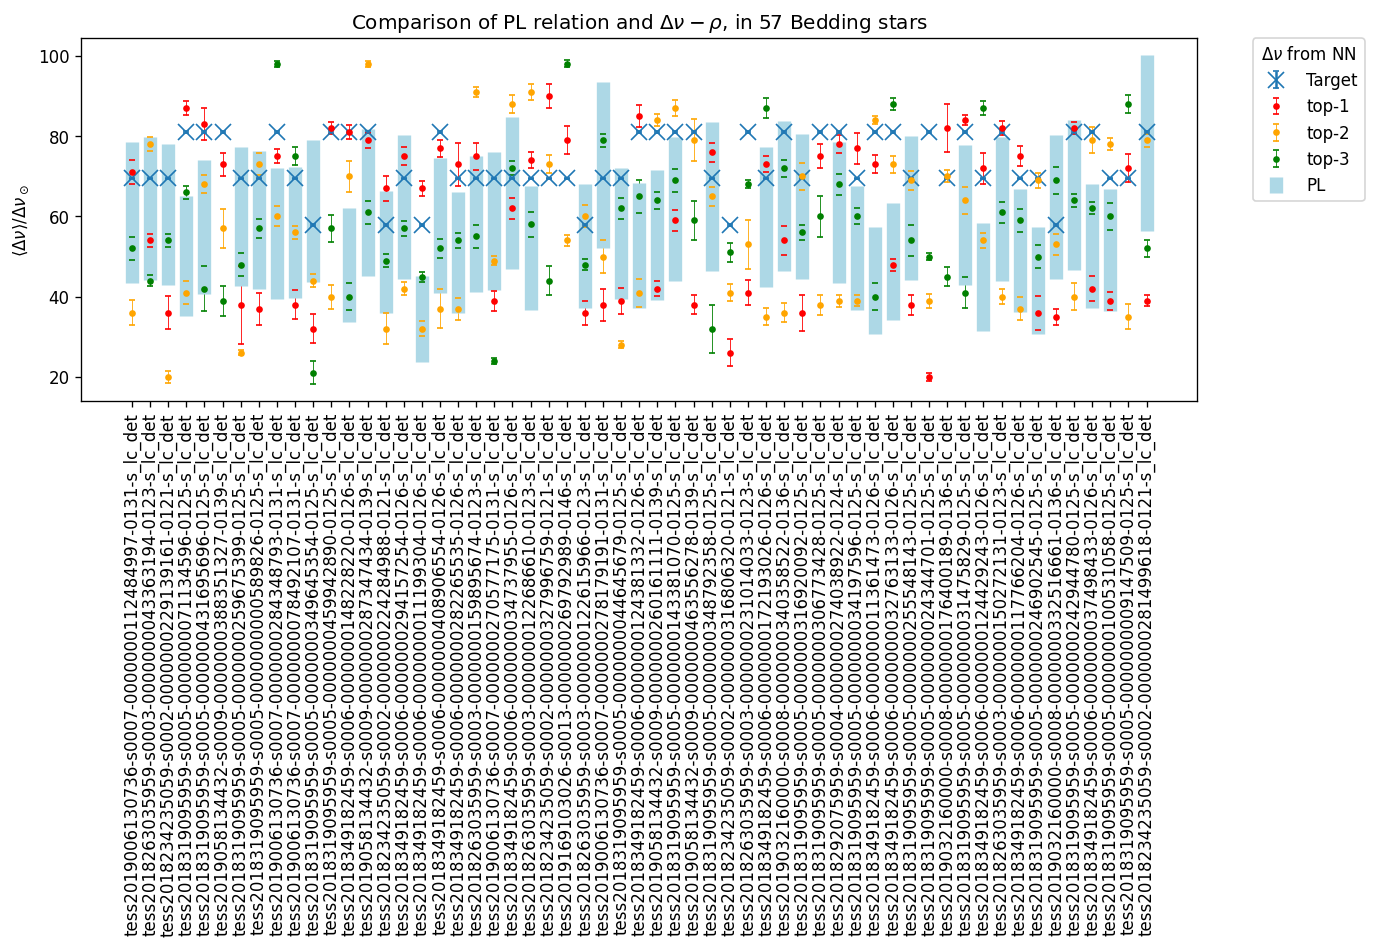

57


In [25]:
plt.subplots(1, figsize=(12, 4), dpi=120)

plt.errorbar(
    df["id"],
    df["dnu-target"],
    0.23,
    fmt="x",
    markersize=10,
    capsize=2,
    label="Target"
)

plt.errorbar(
    df["id"],
    df["top1"],
    df["e-top1"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="red",
    label="top-1",
)
plt.errorbar(
    df["id"],
    df["top2"],
    df["e-top2"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="orange",
    label="top-2",
)
plt.errorbar(
    df["id"],
    df["top3"],
    df["e-top3"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="green",
    label="top-3",
)
"""
plt.errorbar(
    df["id"],
    (df["dnu-from-P-up-fromstarmodel"] + df["dnu-from-P-down-fromstarmodel"]) / 2,
    df["dnu-from-P-up-fromstarmodel"] - ((df["dnu-from-P-up-fromstarmodel"] + df["dnu-from-P-down-fromstarmodel"]) / 2),
    elinewidth=8,
    fmt="o",
    markersize=0,
    capsize=10,
    label="PL-From Teff",
    color="blue",
)
"""
plt.errorbar(
    df["id"],
    (df["dnu-from-P-up"] + df["dnu-from-P-down"]) / 2,
    df["dnu-from-P-up"] - ((df["dnu-from-P-up"] + df["dnu-from-P-down"]) / 2),
    elinewidth=8,
    fmt="o",
    markersize=0,
    capsize=0,
    label="PL",
    color="lightblue",
)

plt.xticks(rotation=90)

plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.0,
    title=r"$\Delta\nu$ from NN",
)
#plt.gca().add_artist(legend1)
plt.ylabel("$\langle\Delta\\nu\\rangle / \Delta\\nu_\odot$")
plt.title("Comparison of PL relation and $\Delta\\nu-\\rho$, in 57 Bedding stars")
#plt.ylim(0, 1.0)
plt.show()
print(len(df.index))

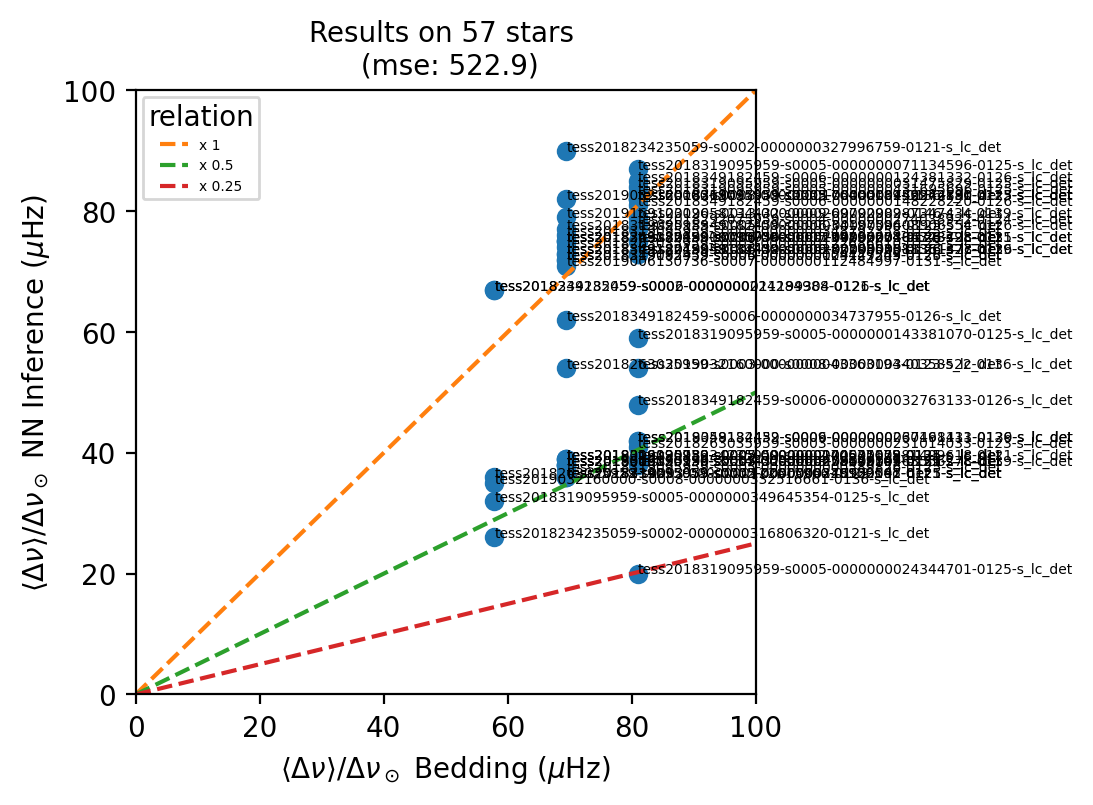

In [26]:
# Prepare data plot
targets = []
inferences = []
ids = []
for tess_id in results:
    ids.append(tess_id)
    targets.append(results[tess_id]["dnu-target"])
    inferences.append(results[tess_id]["top1"])
    
# Set lims
plt.subplots(1, figsize=(4, 4), dpi=200)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.plot(targets, inferences, "o") # Plot relation
for i, txt in enumerate(ids):
    plt.annotate(txt, (targets[i], inferences[i]), size=5)

# Add multiple and submultiples
abline(1, 0)
abline(0.5, 0)
abline(0.25, 0)
plt.legend(title="relation", fontsize=5)
plt.xlabel("$\langle\Delta\\nu\\rangle / \Delta\\nu_\odot$ Bedding ($\mu$Hz)")
plt.ylabel("$\langle\Delta\\nu\\rangle / \Delta\\nu_\odot$ NN Inference ($\mu$Hz)")
plt.title("Results on 57 stars \n (mse: %s)" % np.round(np.mean(np.power(np.asarray(targets)-np.asarray(inferences), 2)),2), fontsize=10)
plt.show()

In [27]:
results_bedding= pd.DataFrame(
    columns=[
        "id",
        "dnu-target",
        "e-dnu-target",
        "dnu-from-P",
        "e-dnu-from-P",
        "best-top",
        "e-best-top",
        "ktop",
    ]
)

for index, row in df.iterrows():
    print("Proccessing star %s" % row["id"])
    print("PL[%f,%f]" % (row["dnu-from-P-up"], row["dnu-from-P-down"]))
    # Top index to search on 
    top_indexs = ["top1", "top2", "top3"]
    best = np.nan # empty on start
    # Center of PL window
    central_pl_window = row["dnu-from-P-up"]-((row["dnu-from-P-up"]-row["dnu-from-P-down"])/2)
    # Check predictions indise L window
    inside_pl_window = []
    for top_index in top_indexs:
        flag_full_inside = (row[top_index] + row["e-%s" % (top_index)] <= row["dnu-from-P-up"]) & (row[top_index] - row["e-%s" % (top_index)] >= row["dnu-from-P-down"])
        flag_partial =  ((row[top_index] - row["e-%s" % (top_index)] >= row["dnu-from-P-down"]) & (row[top_index] - row["e-%s" % (top_index)] <= row["dnu-from-P-up"])) | ((row[top_index] + row["e-%s" % (top_index)] >= row["dnu-from-P-down"]) & (row[top_index] + row["e-%s" % (top_index)] <= row["dnu-from-P-up"])) 
        if flag_full_inside or flag_partial:
            inside_pl_window.append(top_index)
    print("   =>Inside PL window: %s" % inside_pl_window)

    if (len(inside_pl_window) > 0) and (not np.isnan(row["dnu-from-P-up"])):
        print("=>",inside_pl_window)
        top_index = inside_pl_window[0] # Get most probable from NN
        
        # Get best
        best = row["%s" % (top_index)]
        results_bedding.loc[len(results_bedding)] = [
                        row["id"],
                        row["dnu-target"],
                        0.23,
                        (row["dnu-from-P-up"] + row["dnu-from-P-down"]) / 2,
                        row["dnu-from-P-up"] - ((row["dnu-from-P-up"] + row["dnu-from-P-down"]) / 2),
                        best,
                        row["e-%s" % top_index],
                        top_index
                    ]
    else:
        # Get closest inference to the center of PL window
        top_index = np.argmin([np.abs(row[top_index]-central_pl_window) for top_index in top_indexs])
        # Check if predictions is not inside window
        # Get best
        best = row["top%s" % (top_index+1)]
        results_bedding.loc[len(results_bedding)] = [
                        row["id"],
                        row["dnu-target"],
                        0.23,
                        (row["dnu-from-P-up"] + row["dnu-from-P-down"]) / 2,
                        row["dnu-from-P-up"] - ((row["dnu-from-P-up"] + row["dnu-from-P-down"]) / 2),
                        best,
                        row["e-top%s" % (top_index+1)],
                        top_index
                    ]

Proccessing star tess2019006130736-s0007-0000000112484997-0131-s_lc_det
PL[78.528288,43.278586]
   =>Inside PL window: ['top1', 'top3']
=> ['top1', 'top3']
Proccessing star tess2018263035959-s0003-0000000043363194-0123-s_lc_det
PL[79.806657,44.039208]
   =>Inside PL window: ['top1', 'top2', 'top3']
=> ['top1', 'top2', 'top3']
Proccessing star tess2018234235059-s0002-0000000229139161-0121-s_lc_det
PL[78.093221,43.019828]
   =>Inside PL window: ['top3']
=> ['top3']
Proccessing star tess2018319095959-s0005-0000000071134596-0125-s_lc_det
PL[65.021403,35.274913]
   =>Inside PL window: ['top2', 'top3']
=> ['top2', 'top3']
Proccessing star tess2018319095959-s0005-0000000431695696-0125-s_lc_det
PL[73.952958,40.560241]
   =>Inside PL window: ['top2', 'top3']
=> ['top2', 'top3']
Proccessing star tess2019058134432-s0009-0000000388351327-0139-s_lc_det
PL[nan,nan]
   =>Inside PL window: []
Proccessing star tess2018319095959-s0005-0000000259675399-0125-s_lc_det
PL[77.361676,42.584862]
   =>Inside PL

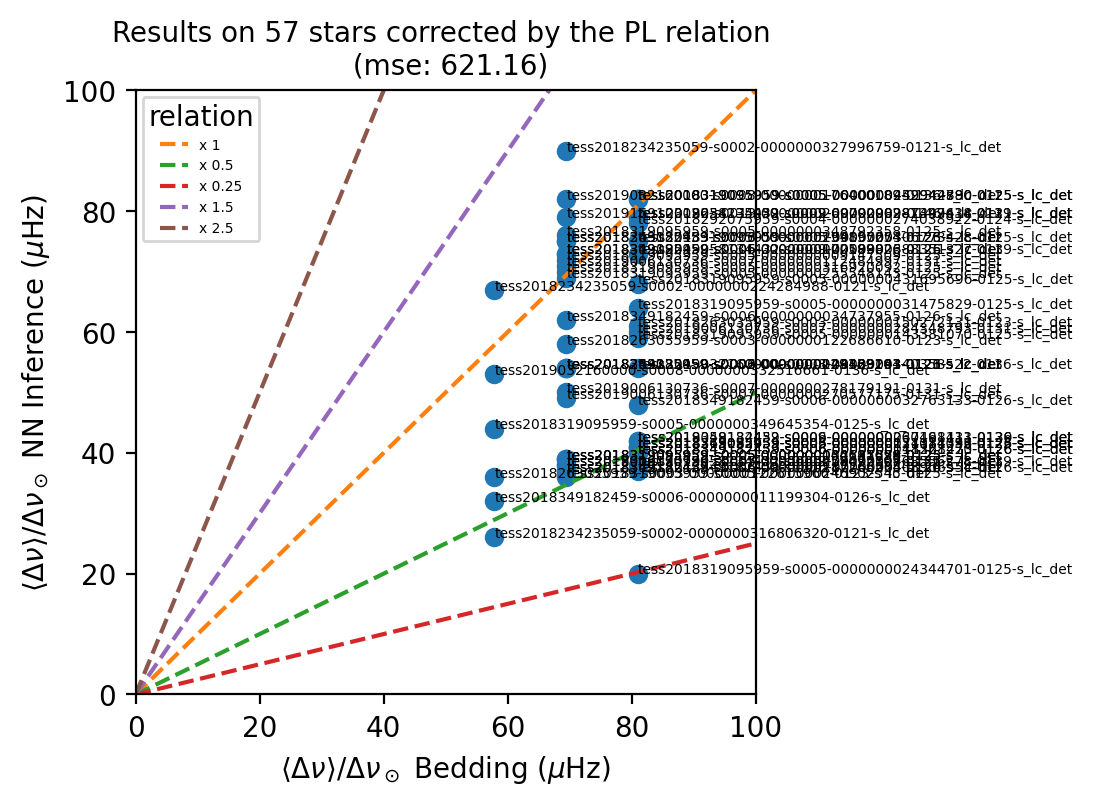

In [28]:
# Prepare data plot
targets = results_bedding["dnu-target"]
inferences = results_bedding["best-top"]
ids = results_bedding["id"]

# Set lims
plt.subplots(1, figsize=(4, 4), dpi=200)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.plot(targets, inferences, "o") # Plot relation
for i, txt in enumerate(ids):
    plt.annotate(txt, (targets[i], inferences[i]), size=5)

# Add multiple and submultiples
abline(1, 0)
abline(0.5, 0)
abline(0.25, 0)
abline(1.5, 0)
abline(2.5, 0)
plt.legend(title="relation", fontsize=5)
plt.xlabel("$\langle\Delta\\nu\\rangle / \Delta\\nu_\odot$ Bedding ($\mu$Hz)")
plt.ylabel("$\langle\Delta\\nu\\rangle / \Delta\\nu_\odot$ NN Inference ($\mu$Hz)")
plt.title("Results on 57 stars corrected by the PL relation \n (mse: %s)" % np.round(np.mean(np.power(np.asarray(targets)-np.asarray(inferences), 2)),2), fontsize=10)
plt.show()